# 01 Import libraries

In [ ]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
import pandas as pd

In [ ]:
import importlib

## Import our own modules

In [ ]:
!rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

rm: cannot remove 'Learning-the-Optimal-Solution-Path': No such file or directory
Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 1659, done.
remote: Counting objects: 100% (629/629), done.
remote: Compressing objects: 100% (270/270), done.
remote: Total 1659 (delta 477), reused 479 (delta 359), pack-reused 1030
Receiving objects: 100% (1659/1659), 13.23 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (1114/1114), done.


(Using Colab)

In [ ]:
import sys

In [ ]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [ ]:
import lib
importlib.reload(lib)

<module 'lib' from '/content/Learning-the-Optimal-Solution-Path/lib/__init__.py'>

In [ ]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.lsp.basis_generator import scaled_shifted_legendre
from lib.lsp.basis_tf_module import Basis_TF_SGD
from lib.lsp.reg_solver_lsp import train_lsp, test_lsp
from lib.lsp.loss_fn_lsp import reg_unif_weighted_logit

# 02 Instantiate dataset

In [ ]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [ ]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [ ]:
input_dim = X.shape[1]

In [ ]:
X_tune = X[:200, :]
y_tune = y[:200]

In [ ]:
train_X = torch.tensor(X_tune, dtype=torch.float32)
train_y = torch.tensor(y_tune, dtype=torch.float32)

In [ ]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=20, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

# 03 Define Functions

In [ ]:
loss_fn = reg_unif_weighted_logit

In [ ]:
def gen_loss_gd(lam, lr):
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    weight = model.linear.weight.clone().detach()
    itr = 0
    for t in range(epochs):
        grad, weight, itr = train_lsp(itr, weight, GD_data_loader, model, loss_fn,
                                      optimizer, weighted_avg=True, step_size=None,
                                      const=None, distribution='uniform', device='cpu')

    loss = test_lsp(test_data_loader, model, loss_fn, lam, device)
    return loss

In [ ]:
def gen_loss_sgd(lam, step_size, const):
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    weight = model.linear.weight.clone().detach()
    itr = 0
    for t in range(epochs):
        grad, weight, itr = train_lsp(itr, weight, SGD_data_loader, model, loss_fn,
                                      optimizer, weighted_avg=True, step_size=step_size,
                                      const=beta, distribution='uniform', device='cpu')
    loss = test_lsp(test_data_loader, model, loss_fn, lam, device)
    return loss

# 04 Tuning the learning rate for our model

In [ ]:
lr_list = 0.5 ** np.arange(-3, 11)
beta_list = 0.5 ** np.arange(-3, 11)

In [ ]:
lam = 0.7

Legendre polynomials

In [ ]:
phi_lam = scaled_shifted_legendre

In [ ]:
epochs = 50

## Basis dimension = 5

In [ ]:
basis_dim = 5

### Exact Gradient:

pick lr = 0.125

In [ ]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: nan
learning rate: 4.0	 loss: 7.908454536325366e+18
learning rate: 2.0	 loss: 172159.34375
learning rate: 1.0	 loss: 2.5829033851623535
learning rate: 0.5	 loss: 1.9055200815200806
learning rate: 0.25	 loss: 0.266883909702301
learning rate: 0.125	 loss: 0.2532311677932739
learning rate: 0.0625	 loss: 0.261111319065094
learning rate: 0.03125	 loss: 0.2657533288002014
learning rate: 0.015625	 loss: 0.281065434217453
learning rate: 0.0078125	 loss: 0.2897779643535614
learning rate: 0.00390625	 loss: 0.30184224247932434
learning rate: 0.001953125	 loss: 0.307359904050827
learning rate: 0.0009765625	 loss: 0.31778645515441895


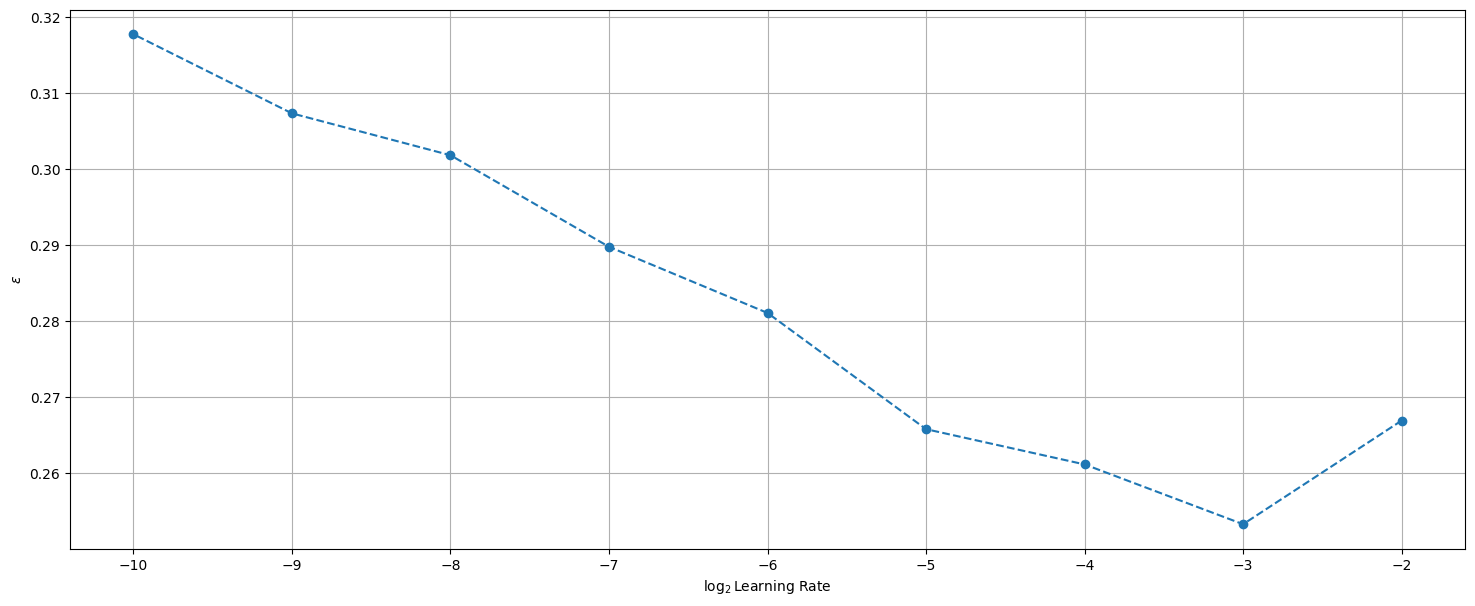

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[5:]), losses[5:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

### Noisy gradient:

In [ ]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

pick $\beta = 0.5$

In [ ]:
losses = []
losses_avg = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, step_size, beta)

    print(f"learning rate: {beta}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: 4.400636196136475
learning rate: 4.0	 loss: 0.3389155864715576
learning rate: 2.0	 loss: 1.4282081127166748
learning rate: 1.0	 loss: 0.3309081196784973
learning rate: 0.5	 loss: 0.25560691952705383
learning rate: 0.25	 loss: 0.2577629089355469
learning rate: 0.125	 loss: 0.26564881205558777
learning rate: 0.0625	 loss: 0.2707703411579132
learning rate: 0.03125	 loss: 0.26986929774284363
learning rate: 0.015625	 loss: 0.28050729632377625
learning rate: 0.0078125	 loss: 0.29021838307380676
learning rate: 0.00390625	 loss: 0.3015720844268799
learning rate: 0.001953125	 loss: 0.3092092275619507
learning rate: 0.0009765625	 loss: 0.31712377071380615


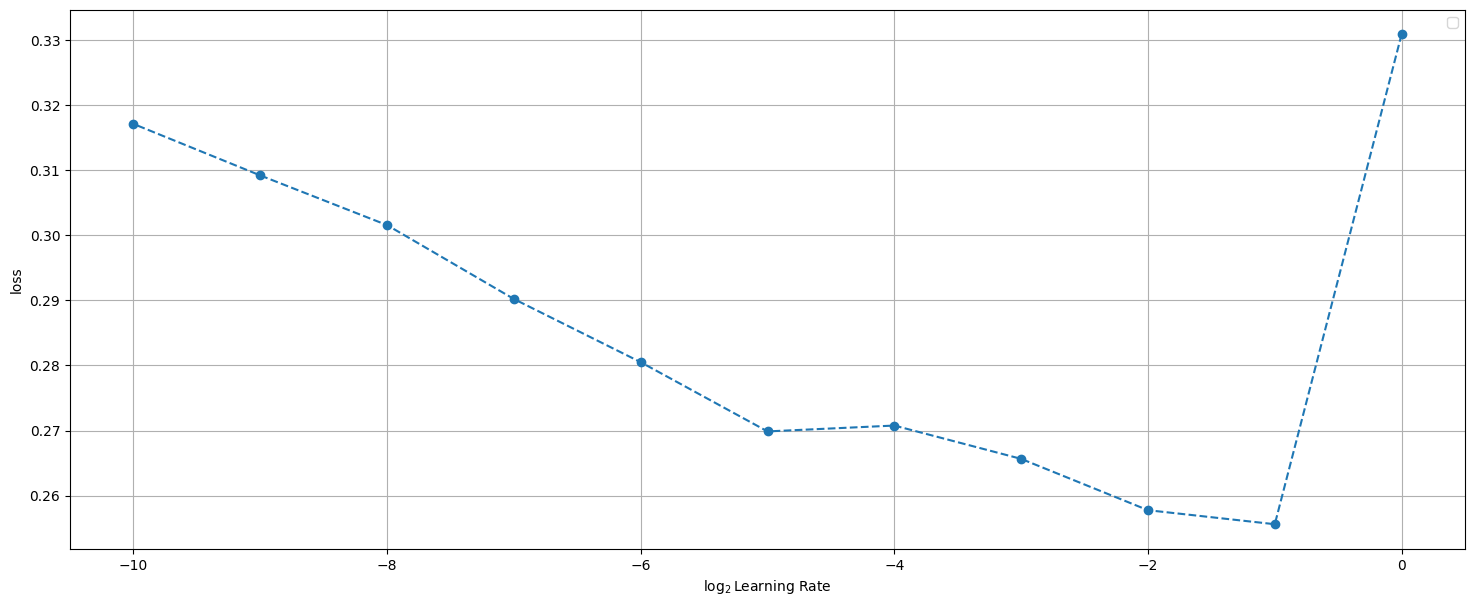

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list[3:]), losses[3:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("loss")
plt.grid(True)

## Basis dimension = 7

In [ ]:
basis_dim = 7

### Exact Gradient:

pick lr = 0.0625

In [ ]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: nan
learning rate: 4.0	 loss: 2.333138425835261e+22
learning rate: 2.0	 loss: 18991673344.0
learning rate: 1.0	 loss: 1124.2900390625
learning rate: 0.5	 loss: 7.5222930908203125
learning rate: 0.25	 loss: 0.7834891080856323
learning rate: 0.125	 loss: 0.2606239914894104
learning rate: 0.0625	 loss: 0.2573842704296112
learning rate: 0.03125	 loss: 0.270334929227829
learning rate: 0.015625	 loss: 0.27642327547073364
learning rate: 0.0078125	 loss: 0.29420074820518494
learning rate: 0.00390625	 loss: 0.3056986331939697
learning rate: 0.001953125	 loss: 0.30492207407951355
learning rate: 0.0009765625	 loss: 0.31542322039604187


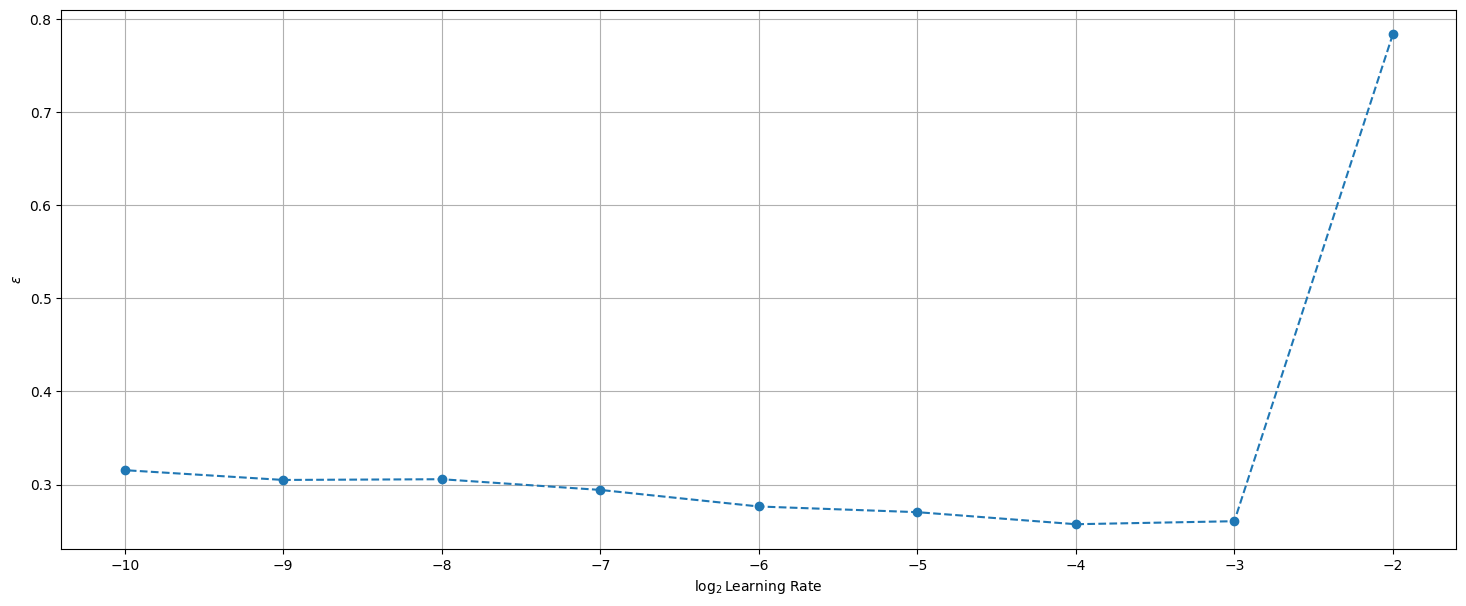

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[5:]), losses[5:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

### Noisy gradient:

In [ ]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

pick $\beta = 0.125$

In [ ]:
losses = []
losses_avg = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, step_size, beta)

    print(f"learning rate: {beta}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: 229.05958557128906
learning rate: 4.0	 loss: 0.633895754814148
learning rate: 2.0	 loss: 4.987822532653809
learning rate: 1.0	 loss: 1.0880451202392578
learning rate: 0.5	 loss: 0.2838118374347687
learning rate: 0.25	 loss: 0.2565973401069641
learning rate: 0.125	 loss: 0.2544996440410614
learning rate: 0.0625	 loss: 0.2601326107978821
learning rate: 0.03125	 loss: 0.2752389907836914
learning rate: 0.015625	 loss: 0.2843754291534424
learning rate: 0.0078125	 loss: 0.28801172971725464
learning rate: 0.00390625	 loss: 0.29601460695266724
learning rate: 0.001953125	 loss: 0.30937129259109497
learning rate: 0.0009765625	 loss: 0.3146258294582367


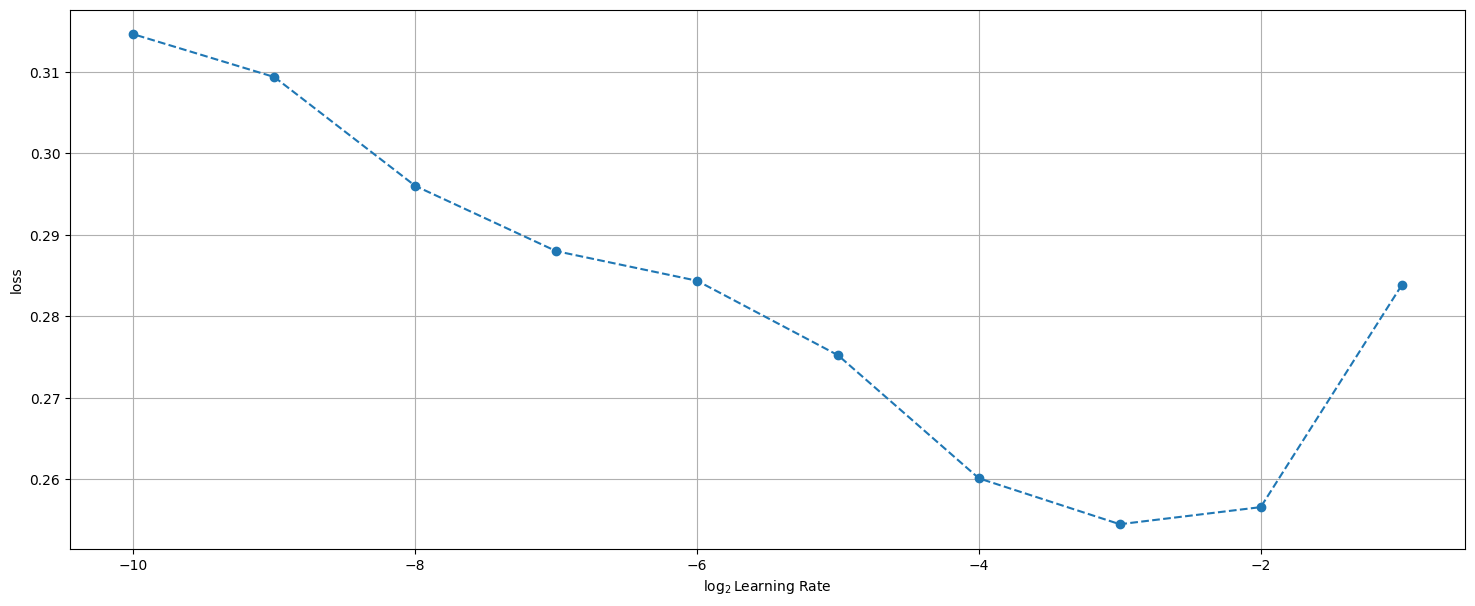

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list[4:]), losses[4:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("loss")
plt.grid(True)

## Basis dimension = 9

In [ ]:
basis_dim = 9

### Exact Gradient:

pick lr = 0.0625

In [ ]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: nan
learning rate: 4.0	 loss: 5.4941413614255054e+26
learning rate: 2.0	 loss: 1492936818688.0
learning rate: 1.0	 loss: 34.02182388305664
learning rate: 0.5	 loss: 0.6129814386367798
learning rate: 0.25	 loss: 0.6957024335861206
learning rate: 0.125	 loss: 0.26225095987319946
learning rate: 0.0625	 loss: 0.2554778754711151
learning rate: 0.03125	 loss: 0.27225324511528015
learning rate: 0.015625	 loss: 0.2721126079559326
learning rate: 0.0078125	 loss: 0.2985472083091736
learning rate: 0.00390625	 loss: 0.2980744242668152
learning rate: 0.001953125	 loss: 0.31128013134002686
learning rate: 0.0009765625	 loss: 0.3137250542640686


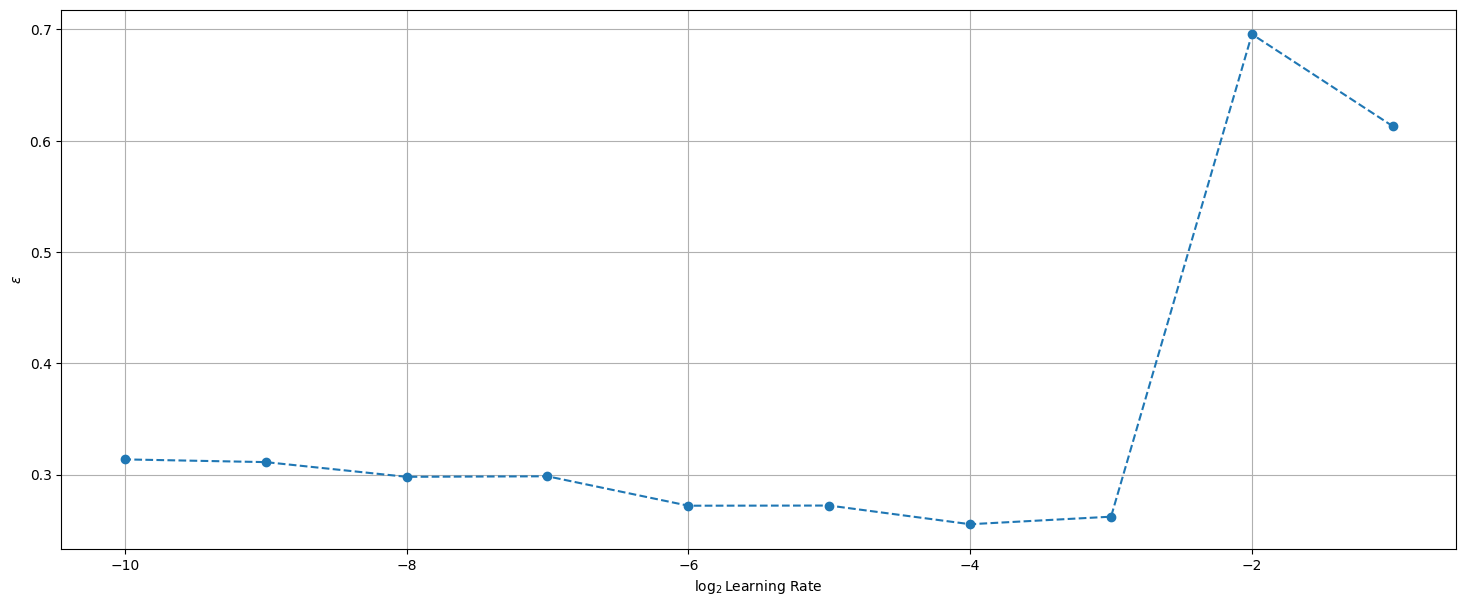

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[4:]), losses[4:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

### Noisy gradient:

In [ ]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

pick $\beta = 0.0625$

In [ ]:
losses = []
losses_avg = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, step_size, beta)

    print(f"learning rate: {beta}\t loss: {loss}")
    losses.append(loss)

learning rate: 8.0	 loss: 4.901122472935424e+16
learning rate: 4.0	 loss: 67573.515625
learning rate: 2.0	 loss: 0.2664288580417633
learning rate: 1.0	 loss: 0.2982513904571533
learning rate: 0.5	 loss: 0.2760160267353058
learning rate: 0.25	 loss: 0.2871377766132355
learning rate: 0.125	 loss: 0.2632593512535095
learning rate: 0.0625	 loss: 0.2595648765563965
learning rate: 0.03125	 loss: 0.2690836787223816
learning rate: 0.015625	 loss: 0.28747549653053284
learning rate: 0.0078125	 loss: 0.2889598608016968
learning rate: 0.00390625	 loss: 0.3041825294494629
learning rate: 0.001953125	 loss: 0.31162652373313904
learning rate: 0.0009765625	 loss: 0.3169117867946625


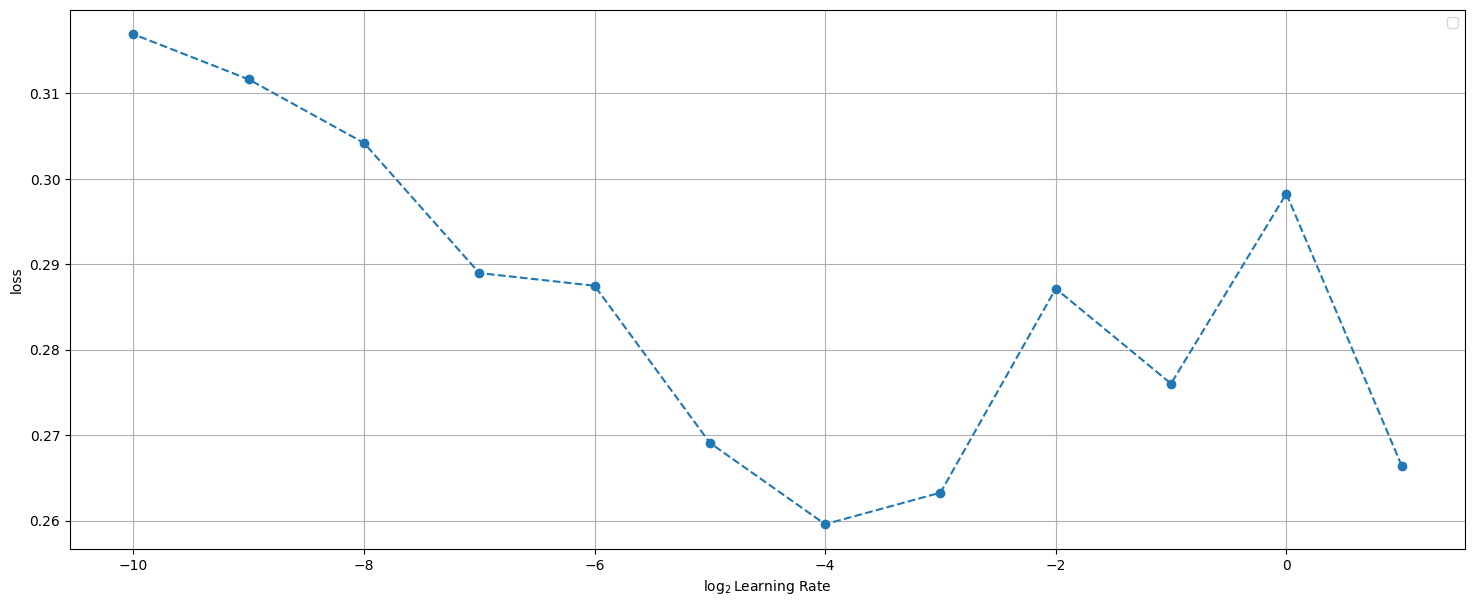

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list[2:]), losses[2:], '--o')
plt.legend()
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("loss")
plt.grid(True)